# Covid-19 Report / Dashboard

The following is a list of steps taken for the creation of the Covid-19 Dashboard at https://datastudio.google.com/s/s4U9oFwAABQ

## Data source

The data was gathered from https://ourworldindata.org/ from February 20, 2020 until March 25, 2022. It was downloaded in CSV format.

## Data Cleaning

After getting the data, it was opened in MS Excel and cleaned/normalized by ensuring all columns had uniform data and no data was duplicated.

## Data Transformation

Once the data had been clean and normalized, I moved the population column so it was 5th in order along the demographics and took the first columns (demographics) with the first part of columns (information about deaths mostly) and exported it as CSV. Then I took the later columns (mostly about vaccination) and pair it alongside the demographic columns and exported that as well.

Once I had two CSV files, each one with less columns than the original file, I created a new database in MS SQL and imported them as tables. OOnce I checked everything was imported correctly (quantity of rows in each table and columns structure), I proceeded to make the necessary aggregations for the analysis.

## Aggregation in SQL

This is a short summary of the most important queries excecuted in the database.

First I calculated the overall totals worldwide:

- Total Covid-19 cases
- Total Covid-19 related deaths
- Percentage from total Covid-19 that ended in deaths

```
-- Total cases vs. total deaths worldwide
SELECT SUM(new_cases) AS new_cases, SUM(CAST(new_deaths AS bigint)) AS new_deaths, SUM(CAST(new_deaths AS bigint)) / SUM(new_cases) * 100 AS death_pct
FROM [covid-db].dbo.deaths
WHERE continent IS NOT NULL
ORDER BY 1, 2
```

Then I added all the cases for each country and total deaths reported from Covid-19 and calculated the total death percentage.

```
-- Select cuntries with highest infection rates compared to population
-- without nulls in any column as those countries are not reporting
-- their data. I took out the aggregation by continent that was
-- already in the data.

;WITH highest_infection_vs_pop AS
(
	SELECT
		location,
		population,
		MAX(total_cases) AS highest_infection_count,
		MAX(((total_cases / population)) * 100) / 100 AS contagion_pct
	FROM [covid-db].dbo.deaths
	WHERE continent IS NOT NULL
	GROUP BY location, population
)
SELECT *
FROM highest_infection_vs_pop
WHERE population IS NOT NULL
	AND highest_infection_count IS NOT NULL
	AND contagion_pct IS NOT NULL
ORDER BY location
```

Comparison between continents:

```
-- Comparing deaths by continent
SELECT
    location,
    MAX(CAST(total_deaths AS bigint)) AS total_death_count
FROM [covid-db].dbo.deaths
WHERE continent IS NULL --Take only countries into account and not countries grouped by continent
    AND location != 'World' -- Take out total sum
    AND location NOT LIKE '%income%' -- Take out divisions
    AND location != 'European Union' -- Take out divisions
    AND location != 'International' -- Take out divisions
GROUP BY location
ORDER BY total_death_count DESC
```
Filtered to get the total cases vs. how countries have managed it

```
-- Total cases vs total icu patients vs total vaccines
SELECT
	deaths.location,
	deaths.date,
	deaths.total_cases,
	deaths.total_deaths,
	deaths.icu_patients,
	CAST(vaccines.people_vaccinated AS bigint) AS first_shot,
	CAST(vaccines.people_fully_vaccinated AS bigint) AS second_shot,
	CAST(vaccines.total_boosters AS bigint) AS booster
	--(CAST(vaccines.people_vaccinated AS bigint) / deaths.population * 100) / 100 AS population_1_shot_pct,
	--(CAST(vaccines.people_fully_vaccinated AS bigint) / deaths.population * 100) / 100 AS population_2_shots_pct,
	--(CAST(vaccines.total_boosters AS bigint) / deaths.population * 100) / 100 AS population_booster_pct
FROM [covid-db].dbo.deaths AS deaths
JOIN [covid-db].dbo.vaccinations AS vaccines
	ON deaths.location = vaccines.location
	AND deaths.date = vaccines.date
WHERE deaths.continent IS NOT NULL
--AND deaths.location = 'Argentina'
--AND vaccines.people_vaccinated IS NOT NULL
ORDER BY 1, 2
```

## Reporting (Dashboard)

Once I had the necessary results from the SQL queries, I exported each one into separate files in MS Excel and saved each one with the appropriate name in CSV format. After I had all of the files ready, I created a new set of data sources and a new report in Google Data Studio. Then began creating the report.

This is a screenshot of the dashboard. The live version can be found at https://datastudio.google.com/s/s4U9oFwAABQ


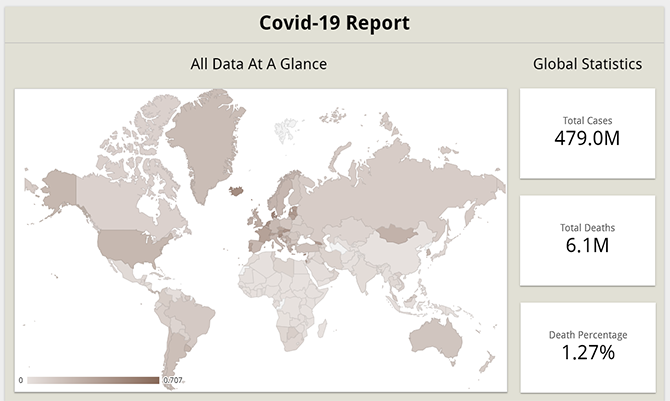